## py_otomoto

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('my_df.csv')
df.head(3)

,offer_id,city,region,model,year,mileage,fuel_type,displacement,price,currency,pub_date,duration,end_price
0,6069449316,Prudnik,Opolskie,Toyota Yaris II,2009,153000,Diesel,-1,12999,PLN,2019-12-31,13,12999
1,6068202189,Włocławek,Kujawsko-pomorskie,Toyota Yaris II,2008,110000,Benzyna,1298,17600,PLN,2019-12-31,41,16900
2,6067206317,Łódź,Łódzkie,Toyota Yaris II,2010,167938,Diesel,1364,13999,PLN,2019-12-31,61,13900


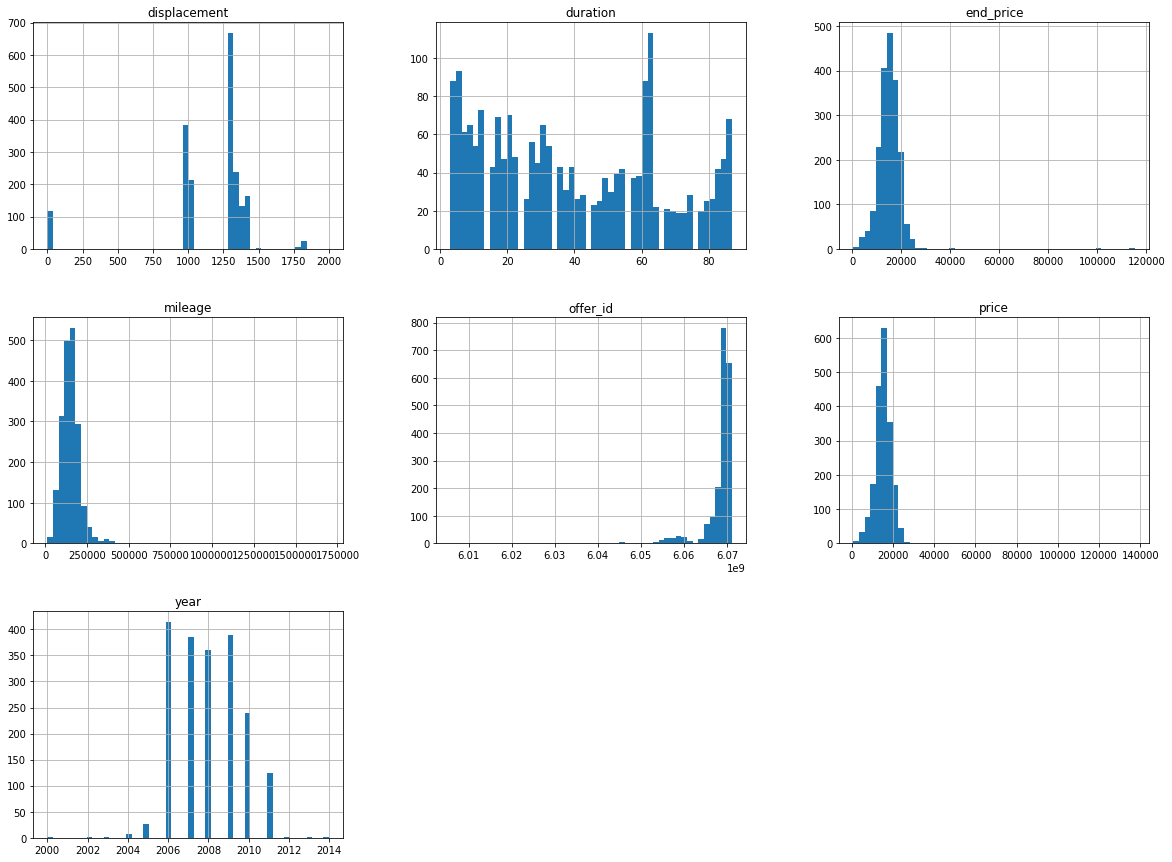

In [3]:
df.hist(bins=50,figsize=(20,15))
plt.show()

### Pojemność silnika

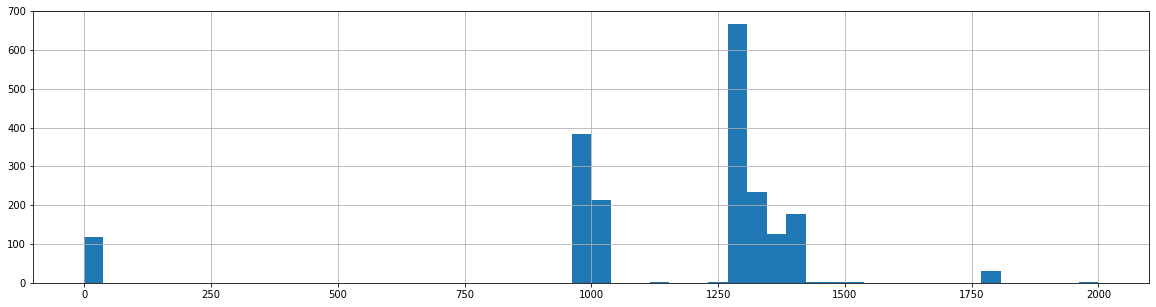

In [17]:
disp_counter = df['displacement'].nunique()
df['displacement'].hist(bins=disp_counter,figsize=(20,5))
plt.show()

### Czas trwania ogłoszenia

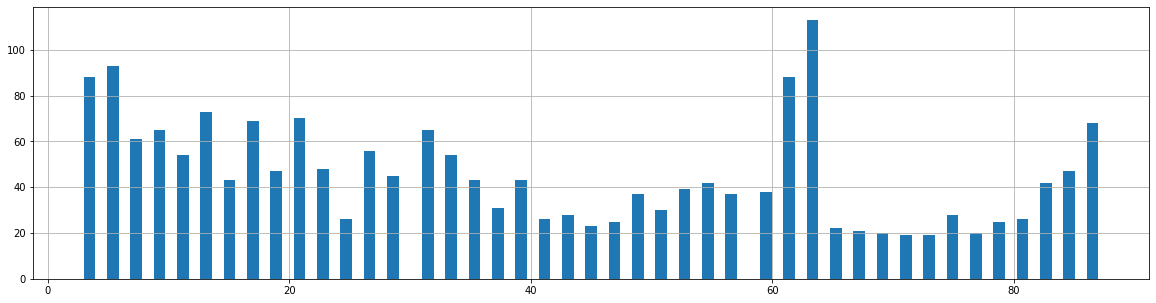

In [14]:
offer_duration = df['duration'].max()
df['duration'].hist(bins=offer_duration,figsize=(20,5))
plt.show()

### Cena końcowa

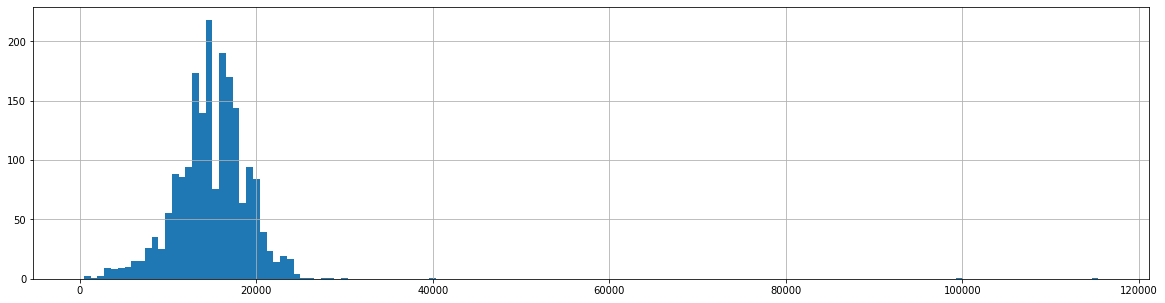

In [31]:
df['end_price'].hist(bins=150,figsize=(20,5))
plt.show()

In [20]:
filter_max = np.percentile(df['end_price'],99)
filter_max

23900.0

### Cena końcowa - 99 percentyl

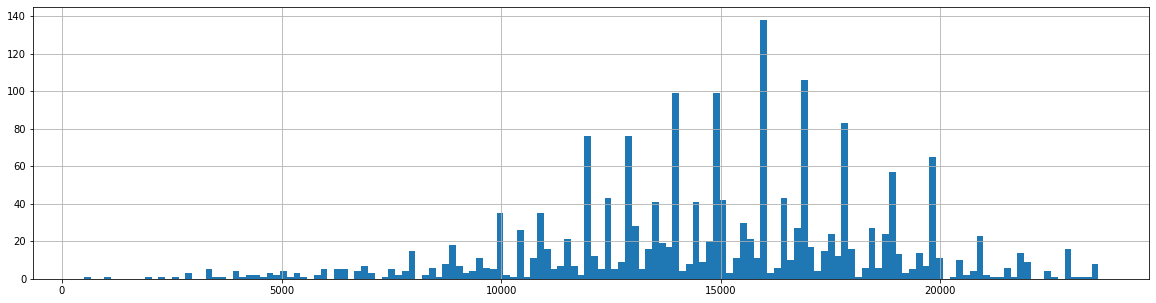

In [32]:
df_filter = df[df['end_price'] < filter_max]
df_filter['end_price'].hist(bins=150,figsize=(20,5))
plt.show()

### Przebieg

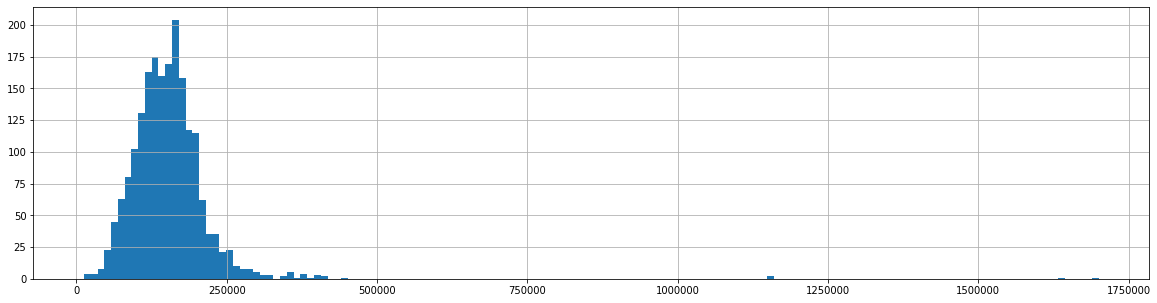

In [33]:
df['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

### Przebieg - 99 percentyl

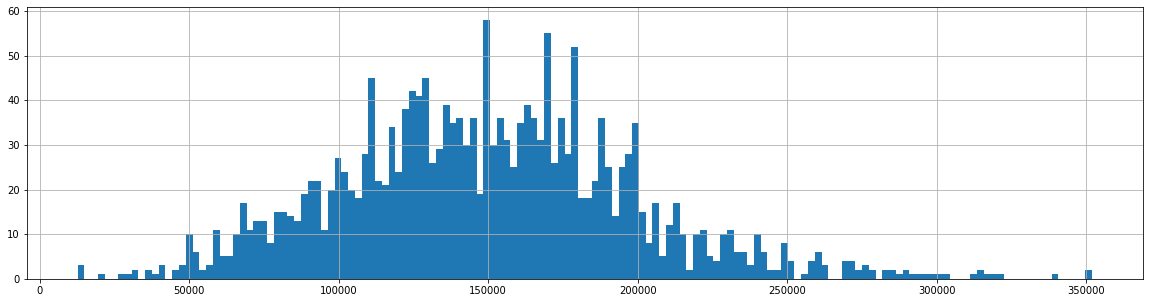

In [36]:
df_mileage = df[df['mileage'] < np.percentile(df['mileage'],99)]
df_mileage['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

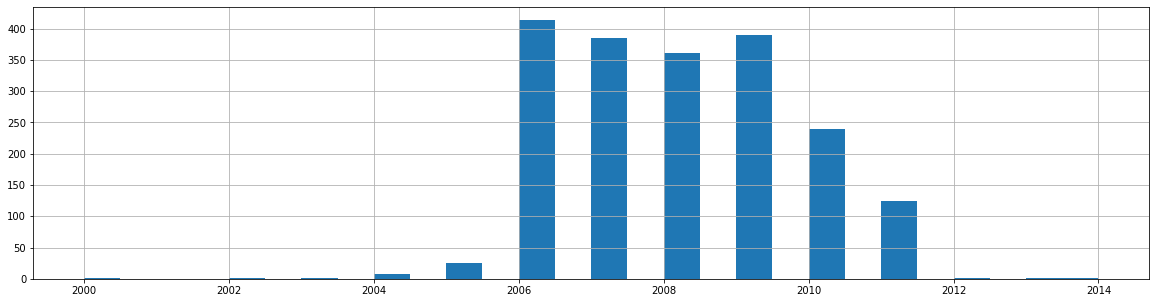

In [39]:
offer_year = df['year'].nunique()*2
df['year'].hist(bins=offer_year,figsize=(20,5))
plt.show()

In [ ]:
# TODO:
# Różnica price - endprice
